## SDPR Testing
This notebook illustrates some features of the SDPR function within `pecotmr` in contrast with the original version of SDPR function [available online here](https://github.com/eldronzhou/SDPR). SDPR is a method for summary-statistics based Dirichlet Process regression. Dirichlet Process regression allows for a flexible generalization of a mixture-of-normals Bayesian prior, with a number of composite distributions that differ in terms of variance. The updated code in this package uses the Armadillo library rather than the GSL library for computation. This solves some problems but has introduced a couple more.

The original version of SDPR was observed to shrink all posterior estimates to zero, while our updated version shrinks most estimates to zero, while preserving a few posterior estimates close to their marginal estimates. This is in line with what would be expected by this Bayesian Variable selection method.

### Load Packages

In [1]:
setwd("~/pecotmr/inst/prototype/SDPR_testing/")
library(dplyr)
library(ggplot2)
library(pecotmr)
library(vroom)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last




### Example 1: Original SDPR Test Data
To illustrate the difference between the `pecotmr` version of SDPR and the original, we compare the posterior estimates effect sizes on the same data. These data are regression summary statistics for an unknown phenotype against 5,000 SNPs in chromosome 22. We use the same marginal effect sizes as the original code, and use LD data from the original code as well. For more details on this example, see the [original SDPR code and description](https://github.com/eldronzhou/SDPR) on github.

In the original code, LD was calculated using the LDetect algorithm with a cutoff r^2 of 0.1. We retrieved the partitions from the original code, and use the first partition (315 SNPs) here for illustration.

In [2]:
# Load Data 
marginal_rss = vroom("marginal_rss.txt")
original_posterior = vroom("SDPR_chr22.txt")
LD_mat = as.matrix(vroom("output_matrix_1.txt"))

# Select to first partition
marginal_rss = marginal_rss[1:nrow(LD_mat),]
original_posterior = original_posterior[1:nrow(LD_mat),]

In [3]:
# Run SDPR with identical MCMC parameters
pecotmr_posterior = sdpr(bhat = marginal_rss$BETA, LD = list(blk1 = LD_mat), n = 503, iter=1000, burn=200, thin=5)

Below we will generate three plots comparing the marginal RSS, the original posterior estimates, and the `pecotmr` posterior estimates. While the marginal estimates range from about -0.3 to 0.3, the orignal posterior estimates range only from -0.0015 to 0.0015, a shrinkage of about 200x. 

In contrast, `pecomtr` provides posterior estimates that range from -0.3 to 0.2, though the majority of the estimates are close to 0. 

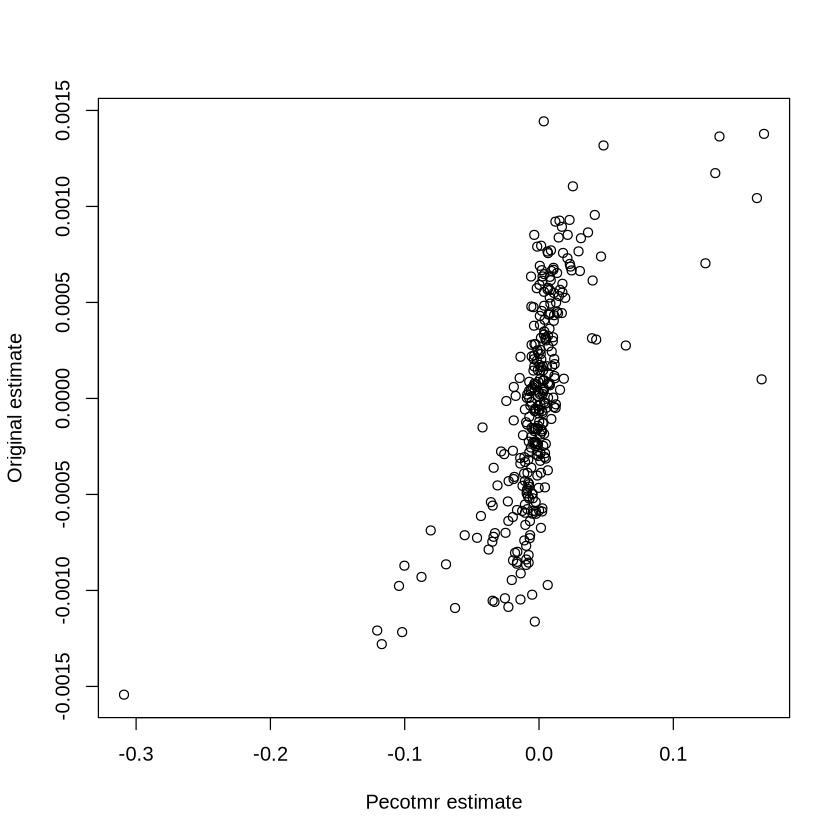

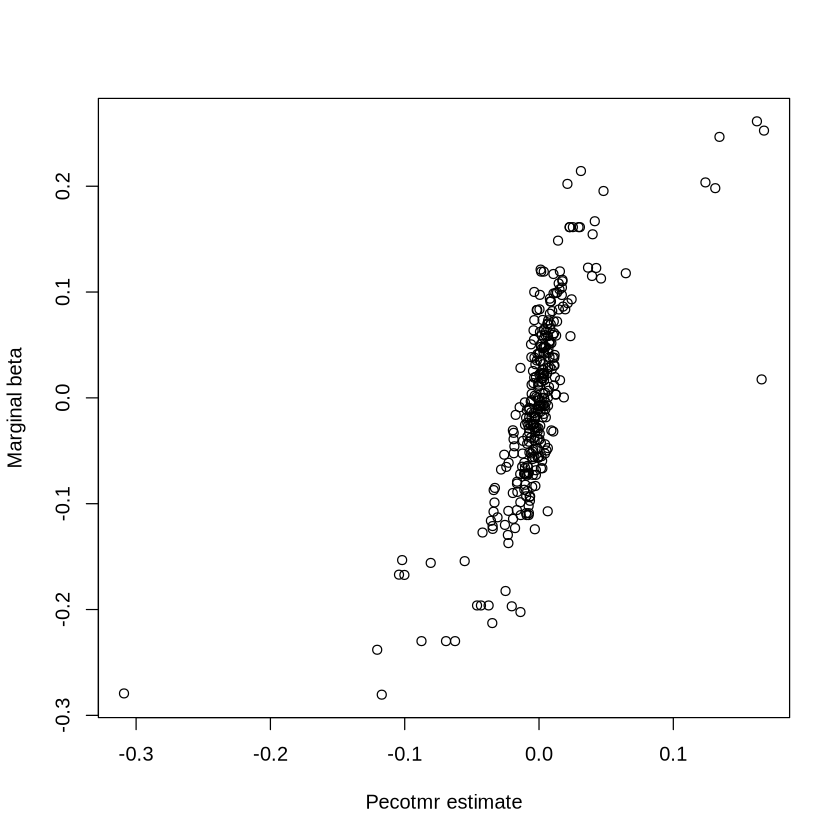

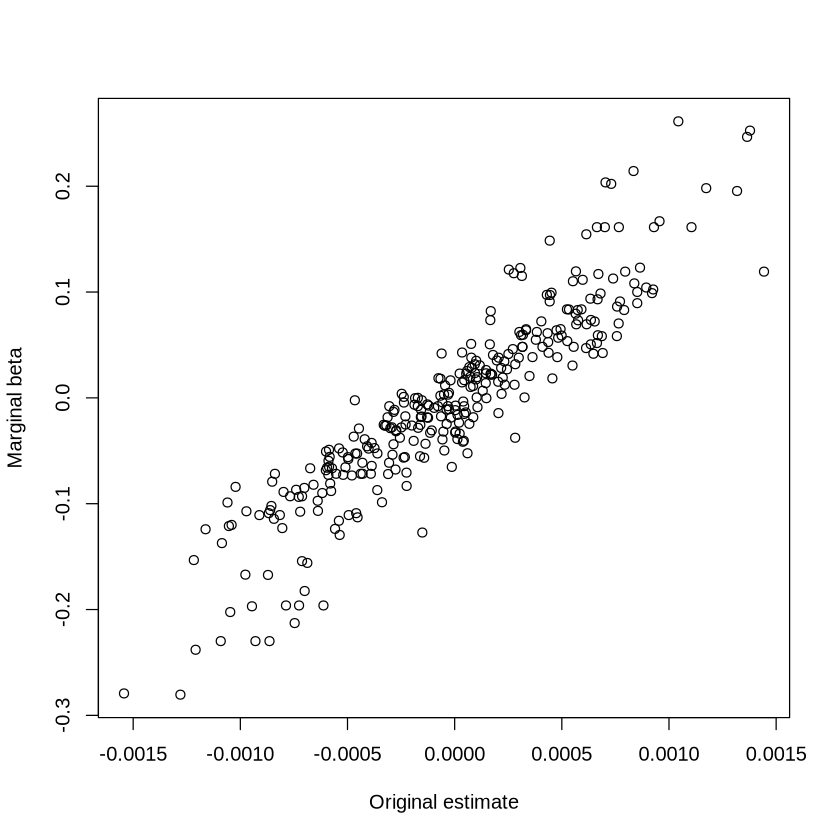

In [4]:
plot(pecotmr_posterior$beta_est, original_posterior$beta, 
     xlab="Pecotmr estimate", 
     ylab="Original estimate")

plot(pecotmr_posterior$beta_est, marginal_rss$BETA, 
     xlab="Pecotmr estimate", 
     ylab="Marginal beta")

plot(original_posterior$beta[1:nrow(LD_mat)], marginal_rss$BETA, 
     xlab="Original estimate", 
     ylab="Marginal beta")

The original SDPR estimates appear to be a linear shrinkage to 0. We find this to defy expectations of SDPR behavior. In contrast, the `pecotmr` performance is more in line with expectation.

### Example 2: Correlations of `pecotmr` SDPR with other methods
Since we found the `pecomtr` posterior estimates to be in line with our expectations for a Bayesian variable selection method, we decided to compare the SDPR posterior means with those from other Bayesian variable selection methods. 

Our interest is in pQTL calculations, so for this example we have RSS data from plasma ADAMTS13 levels with a region of chromosome 10, containing information for approximately 2,000 SNPs. The other methods we directly compare below are BayesL (which uses a Laplace distribution prior) and PRS-CS (which uses a continuous shrinkage prior).  

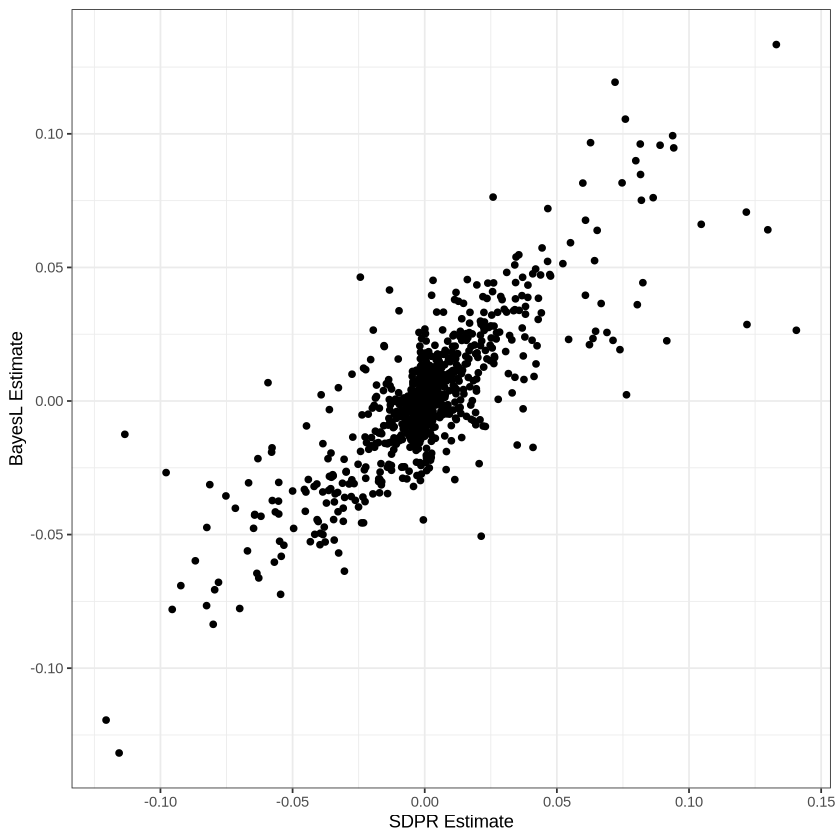

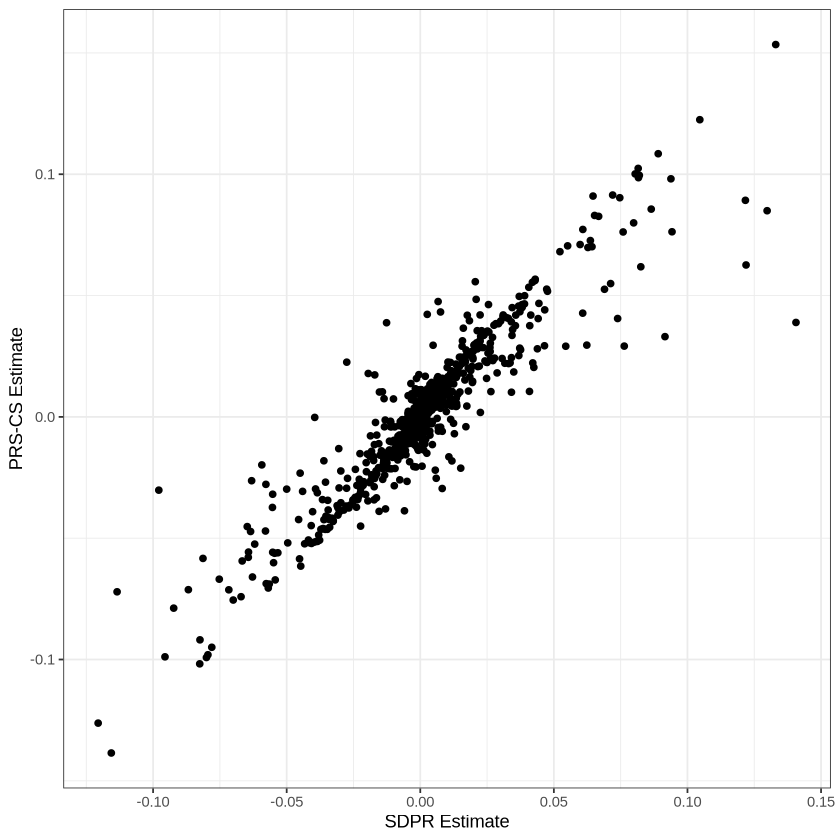

In [5]:
df_post <- vroom("~/chr10_region_posterior.csv")

df_post |>
    ggplot(aes(x = sdpr_weights, y = bayes_l_rss_weights)) + 
    geom_point() + 
    labs(x = "SDPR Estimate", y = "BayesL Estimate") + 
    theme_bw()

df_post |>
    ggplot(aes(x = sdpr_weights, y = prs_cs_weights)) + 
    geom_point() + 
    labs(x = "SDPR Estimate", y = "PRS-CS Estimate") + 
    theme_bw()


The high correlation of posterior estimates, across the same order of magnitude, speaks to the fact that this method is working as expected.

Further, the entire correlation matrix of the different methods is presented below, which shows that SDPR performs at a comparable level to other Bayesian methods. For this reason, we find that the alterations to the SDPR method within `pecotmr` do not inhibit, and in fact maintain, the method's use within the context of RSS analysis.

In [6]:
cor(df_post)

,bayes_r_rss_weights,bayes_n_rss_weights,bayes_c_rss_weights,bayes_a_rss_weights,bayes_l_rss_weights,sdpr_weights,prs_cs_weights,mr_ash_rss_weights
bayes_r_rss_weights,1.0000000,0.2879336,0.14998743,0.8218989,0.10495568,0.24340406,0.11348849,0.20280184
bayes_n_rss_weights,0.2879336,1.0000000,0.18800324,0.3383411,0.23922169,0.26633723,0.28806884,0.10722769
bayes_c_rss_weights,0.1499874,0.1880032,1.00000000,0.1322514,0.02872360,0.09229381,0.05118329,0.11521274
bayes_a_rss_weights,0.8218989,0.3383411,0.13225138,1.0000000,0.11434606,0.22510858,0.12582161,0.21577579
bayes_l_rss_weights,0.1049557,0.2392217,0.02872360,0.1143461,1.00000000,0.80632912,0.83007481,0.02746406
sdpr_weights,0.2434041,0.2663372,0.09229381,0.2251086,0.80632912,1.00000000,0.91797549,0.03933609
prs_cs_weights,0.1134885,0.2880688,0.05118329,0.1258216,0.83007481,0.91797549,1.00000000,0.04182749
mr_ash_rss_weights,0.2028018,0.1072277,0.11521274,0.2157758,0.02746406,0.03933609,0.04182749,1.00000000


### Continuing challenges with SDPR
Despite the reasonable performance acheived by the version of SDPR in the `pecotmr` package, there are a couple outstanding issues that have not been resolved. The primary one of these is computational efficiency. This issue comes down to two factors. The original SDPR method employs the LDetect algorithm to partition the LD matrix into ~300-350 SNP submatrices, and handles each matrix indepently. This is extremely efficient, although at the potential cost for bias (SNPs with correlations of +/- 0.3 are occasionally considered independent).

A second factor affecting the computation time of this method is that the code runs into a singular matrix problem. This is due to the fact that the parameter `eta` in the computation gets shrunk to 0. This shrinkage happens because the `denom_sum` parameter increases without bound, reaching 10^50 or higher. This causes `eta` to be sampled from a distribution like N(1e-30, 1e-50). So while certain matrices remain technically positive definite, the reciprocal condition number approaches 0. This apparent singularity of the matrix does not cause an error in the computation, though it will report a warning, e.g. 

`warning: solve(): system is singular (rcond: 1.29036e-17); attempting approx solution`

However, the finding of this approximate solution takes much more time than the direct solution of a linear system. For more details on the computation, see the supplementary note of the original publication, [available here](https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1009697).